In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
import cv2
from argparse import Namespace

import common.loss_utils as loss_utils
import sys
sys.path.append("../RAFT/core")

from raft import RAFT
from utils.utils import InputPadder

In [4]:
args = Namespace(
    model='RAFT/models/raft-kitti.pth',
    small=False,
    mixed_precision=False,
    alternate_corr=False,
)

In [5]:
model = torch.nn.DataParallel(RAFT(args))

In [6]:
DEVICE = torch.device('cuda')
DEVICE

device(type='cuda')

In [10]:
model.load_state_dict(torch.load(args.model))

<All keys matched successfully>

In [11]:
model = model.module
model.to(DEVICE)
model = model.eval()

In [7]:
p = pathlib.Path('data/data_random_300.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [8]:
times.shape, data.shape

((18354,), (18354, 325, 400))

In [9]:
def check_times(tstart, tend):
    # check_times(times[0], times[35])
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

In [10]:

class DataFetcher:
    def __init__(self, times, data, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)

    def _get_crop(self, input_slice, target_slice):
        # roughly over the mainland UK
#         rand_x = self.generator.randint(0, input_slice.shape[2] - 128)
#         rand_y = self.generator.randint(0, input_slice.shape[1] - 128)
        rand_x = (input_slice.shape[2] - 128) // 2
        rand_y = (input_slice.shape[1] - 128) // 2

        # make a data selection
        in_crop = input_slice[:, rand_y : rand_y + 128, rand_x : rand_x + 128]
        target_crop = target_slice[
            :, rand_y + 32 : rand_y + 96, rand_x + 32 : rand_x + 96
        ]

        return in_crop, target_crop

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        src = data[index:index+12]
        trg = data[index+12:index+36]
        x, y = self._get_crop(src, trg)
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = DataFetcher(times, data)

In [11]:
np.random.seed(7)
indices = np.arange(len(ds))
np.random.shuffle(indices)

In [12]:
x, y = ds[0]

In [13]:
x.shape, y.shape

((12, 128, 128), (24, 64, 64))

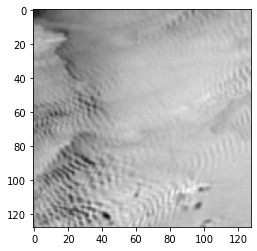

In [14]:
plt.imshow(x[0], cmap='gray')

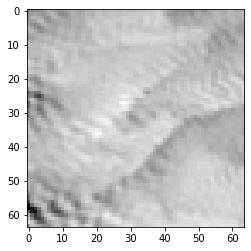

In [15]:
plt.imshow(y[0], cmap='gray')

In [16]:
def warp_flow(img, flow):
    h, w = flow.shape[:2]
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR, borderMode=cv2.BORDER_REPLICATE)
    return res

def get_mssim(y, x, average=True):
    if len(y.shape) == 2:
        # we need to specify a number of channels. This sets it to 1 and calls the function again
        return get_mssim(np.expand_dims(y, 0), np.expand_dims(x, 0))
    if len(y.shape) == 4:
        y = y.reshape(-1, y.shape[2], y.shape[3])
        x = x.reshape(-1, x.shape[2], x.shape[3])
    assert len(y.shape) == 3
    if average:
        mssim_loss = loss_utils.MS_SSIMLoss(data_range=1023, channels=y.shape[0])
        yd = np.expand_dims(y, 0) # /255 * (MAX - MIN) + MIN
        xd = np.expand_dims(x, 0) # /255 * (MAX - MIN) + MIN
        return 1.0 - mssim_loss(
            torch.Tensor(yd),
            torch.Tensor(xd),
        ).item()
    else:
        ret = []
        for i in range(y.shape[0]):
            score = get_mssim(y[i], x[i])
            ret.append(score)
        return ret

In [17]:
LOOKS = 500


In [18]:
def preprocess(x):
    # raft requires me to have data in [0, 255]
    x = x.astype(np.float32)*255.0/1023.0
    # add an RGB channel
    x = np.expand_dims(x, axis=0)
    x = np.tile(x, (3, 1, 1))
    # add a batch dimension
    x = np.expand_dims(x, axis=0)
    return torch.Tensor(x).float().to(DEVICE)

In [123]:
# mean predictors
mean_scores = []
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    preds = np.ones(y.shape) * np.mean(x[-1])
    score = get_mssim(preds, y, average=False)
    mean_scores.append(score)

100%|██████████| 500/500 [00:18<00:00, 27.19it/s]


In [124]:
mean_scores = np.array(mean_scores)
mean_step_means = np.mean(mean_scores, axis=0)
mean_step_stds = np.std(mean_scores, axis=0)

In [121]:
np.mean(mean_scores)

0.6042381940335035

In [122]:
mean_step_means

array([0.5947131 , 0.59389063, 0.59395108, 0.59346445, 0.59351096,
       0.5938146 , 0.59496706, 0.59593715, 0.59676564, 0.59817109,
       0.5988576 , 0.59975199, 0.60089719, 0.6023338 , 0.60425414,
       0.60672175, 0.60891842, 0.61171989, 0.61429426, 0.61655514,
       0.61863497, 0.62109328, 0.62344837, 0.62505008])

In [34]:
# combine classical classical
combined_optical_flow_scores = []
params = {
    'iterations': 1,
    'levels': 10,
    'poly_n': 2,
    'poly_sigma': 1.3358462139572997,
    'pyr_scale': 0.13581496550086464,
    'winsize': 3
}
test_params = {
    'pyr_scale': 0.5,
    'levels': 2,
    'winsize': 40,
    'iterations': 3, 
    'poly_n': 5,
    'poly_sigma': 0.7
}
forecast = 6
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    preds = np.zeros(y.shape, dtype=np.float32)
    cur_feol = x[-1].astype(np.float32)
    cur_beol = x[-1].astype(np.float32)
    flow_feol = cv2.calcOpticalFlowFarneback(
        prev=x[-2],
        next=x[-1],
        flow=None,
        **test_params,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
    )
    flow_beol = cv2.calcOpticalFlowFarneback(
        prev=x[-2],
        next=x[-1],
        flow=None,
        **params,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
    )
    for i in range(forecast):
        cur_feol = warp_flow(cur_feol, flow_feol)
        cur_beol = warp_flow(cur_beol, flow_beol)
        cur_beol = cv2.blur(cur_beol, (3, 3))
        preds[i] = cur_feol[32:96,32:96]
    for i in range(forecast, 24):
        cur_beol = warp_flow(cur_beol, flow_beol)
        cur_beol = cv2.blur(cur_beol, (3, 3))
        preds[i] = cur_beol[32:96,32:96]

    score = get_mssim(preds, y, average=False)
    combined_optical_flow_scores.append(score)
    

100%|██████████| 500/500 [00:22<00:00, 21.97it/s]


In [35]:
combined_optical_flow_scores = np.array(combined_optical_flow_scores)
combined_step_means = np.mean(combined_optical_flow_scores, axis=0)
combined_step_stds = np.std(combined_optical_flow_scores, axis=0)

In [30]:
np.mean(combined_optical_flow_scores)

0.7035286786009868

In [31]:
combined_step_means

array([0.94732114, 0.8874218 , 0.8358762 , 0.79312605, 0.75684718,
       0.7254723 , 0.71111752, 0.69969728, 0.68989919, 0.68185381,
       0.67520599, 0.66936791, 0.66448703, 0.66054242, 0.65703949,
       0.65408842, 0.65171868, 0.6504889 , 0.64866001, 0.64693765,
       0.64587313, 0.6450839 , 0.64387597, 0.64268631])

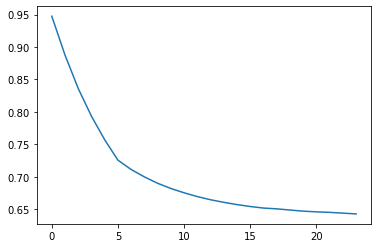

In [33]:
plt.plot(range(24), combined_step_means)

In [78]:
# combine opt flow with classical
combined_optical_flow_scores = []
forecast = 3
for i in tqdm.tqdm(range(LOOKS)):
    x, y = ds[indices[i]]
    prev = preprocess(x[-2])
    cur = preprocess(x[-1])
    with torch.no_grad():
        _, flow = model(prev, cur, iters=20, test_mode=True)
    flow = np.squeeze(flow.cpu().numpy().transpose(0, 2, 3, 1))
    cur = x[-1].astype(np.float32)
    preds = np.zeros(y.shape, dtype=np.float32)
    for j in range(forecast):
        cur = warp_flow(cur, flow)
        preds[j] = cur[32:96,32:96]
    remaining = 24 - forecast
    # mix with classical opt flow
    if remaining > 0:
        flow = cv2.calcOpticalFlowFarneback(
            prev=x[-2],
            next=x[-1],
            flow=None,
            **params,
            flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
        )
        cur = x[-1].astype(np.float32)
        for j in range(24):
            cur = warp_flow(cur, flow)
            cur = cv2.blur(cur, (3, 3))
            if j < forecast:
                continue
            preds[j] = cur[32:96,32:96]

    score = get_mssim(preds, y, average=False)
    combined_optical_flow_scores.append(score)
    

100%|██████████| 500/500 [00:43<00:00, 11.60it/s]


In [79]:
combined_optical_flow_scores = np.array(combined_optical_flow_scores)
combined_step_means = np.mean(combined_optical_flow_scores, axis=0)
combined_step_stds = np.std(combined_optical_flow_scores, axis=0)

In [80]:
np.mean(combined_optical_flow_scores)

0.6989704031795263

In [81]:
combined_step_means

array([0.93150687, 0.86280021, 0.80864567, 0.76562703, 0.74292023,
       0.72516605, 0.71111752, 0.69969728, 0.68989919, 0.68185381,
       0.67520599, 0.66936791, 0.66448703, 0.66054242, 0.65703949,
       0.65408842, 0.65171868, 0.6504889 , 0.64866001, 0.64693765,
       0.64587313, 0.6450839 , 0.64387597, 0.64268631])

In [82]:
# variance
combined_step_stds / combined_step_means

array([0.06990363, 0.11027508, 0.14625198, 0.1831536 , 0.20072331,
       0.21457233, 0.2290726 , 0.23812938, 0.24729417, 0.25742963,
       0.2647005 , 0.27214644, 0.27916121, 0.28418854, 0.29036532,
       0.2972955 , 0.30066129, 0.30160546, 0.30589016, 0.30825234,
       0.30944434, 0.30954027, 0.31125873, 0.31305329])

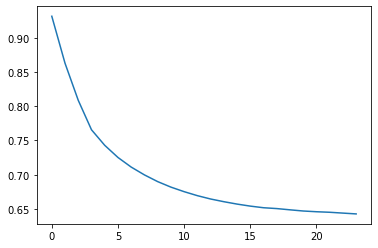

In [83]:
plt.plot(range(24), combined_step_means)